# Feature extraction and classification with traditional machine learning methods

Paulo Roberto DE MOURA JÚNIOR

## Preparing data

Potential features based on:
* https://ieeexplore.ieee.org/document/918473
* https://www.sciencedirect.com/science/article/pii/S0933365712001108#bib0180
* https://arxiv.org/pdf/2106.04372
* https://www.sciencedirect.com/science/article/pii/S0933365713001589

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import cv2
from skimage.feature import graycomatrix, graycoprops, local_binary_pattern
from joblib import Parallel, delayed
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, make_scorer
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from imblearn.over_sampling import ADASYN

In [2]:
class FeatureEstimator:
    def __init__(self, image_folder, mask_folder, image_id):
        self.image_path = image_folder + '/' + image_id + '.jpg'
        self.mask_path = mask_folder + '/' + image_id + '_seg.png'
        self.image = cv2.imread(self.image_path)  # Read image in RGB
        self.mask = cv2.imread(self.mask_path, cv2.IMREAD_GRAYSCALE)  # Read mask in grayscale
        self.mask_float = self.mask.astype(float)/255
        self.contours, _ = cv2.findContours(self.mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
    def asymmetry(self):
        result = {}
        cnt = self.contours[0] if self.contours else None
        
        if cnt is None:
            result['area_difference'] = 0
            result['perimeter_difference'] = 0
        else:
            # Calculate bounding rectangle
            x, y, w, h = cv2.boundingRect(cnt)

            # Split the mask into left and right halves
            left_mask = self.mask[y:y+h, x:x+w//2]
            right_mask = self.mask[y:y+h, x+w//2:x+w]

            # Calculate areas of left and right halves
            area_left = np.sum(left_mask).astype(float)
            area_right = np.sum(right_mask).astype(float)
            
            # Calculate asymmetry metrics
            result['area_difference'] = np.abs(area_left - area_right) / (area_left + area_right)
            
            # Symmetry score based on contour perimeter difference
            contours_left, _ = cv2.findContours(left_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            contours_right, _ = cv2.findContours(right_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            perimeter_left = cv2.arcLength(contours_left[0], True) if contours_left else 0
            perimeter_right = cv2.arcLength(contours_right[0], True) if contours_right else 0
            
            if perimeter_left + perimeter_right == 0:
                result['perimeter_difference'] = 0
            else:
                result['perimeter_difference'] = np.abs(perimeter_left - perimeter_right) / (perimeter_left + perimeter_right)
        
        return result
    
    def border_irregularity(self):
        result = {}
        if not self.contours:
            result['perimeter_ratio'] = 0
            result['area_ratio'] = 0
            result['radial_distance_variance'] = 0
        else:
            lesion_contour = max(self.contours, key=cv2.contourArea)

            # Calculate the perimeter of the lesion contour
            perimeter_lesion = cv2.arcLength(lesion_contour, True)

            # Calculate the convex hull of the lesion contour
            hull = cv2.convexHull(lesion_contour)

            # Calculate the perimeter of the convex hull
            perimeter_hull = cv2.arcLength(hull, True)

            # Calculate the area of the lesion contour
            area_lesion = cv2.contourArea(lesion_contour)

            # Calculate the area of the convex hull
            area_hull = cv2.contourArea(hull)

            # Calculate the centroid of the lesion contour
            moments = cv2.moments(lesion_contour)
            centroid_x = moments["m10"] / moments["m00"] if moments["m00"] != 0 else 0
            centroid_y = moments["m01"] / moments["m00"] if moments["m00"] != 0 else 0

            # Calculate distances from each contour point to the centroid
            distances = [np.linalg.norm(point - (centroid_x, centroid_y)) for point in lesion_contour[:, 0]]

            # Calculate the variance of the radial distance distribution
            result['radial_distance_variance'] = np.var(distances)

            # Calculate border irregularity metrics
            result['perimeter_ratio'] = perimeter_lesion / perimeter_hull if perimeter_hull != 0 else 0  # Perimeter ratio
            result['area_ratio'] = area_lesion / area_hull if perimeter_hull != 0 else 0  # Area ratio
        
        return result
    
    def color_irregularity(self):
        # Convert image to LAB color space
        lab_image = cv2.cvtColor(self.image, cv2.COLOR_BGR2LAB)
        
        # Extract lesion region using the mask
        lesion_region = cv2.bitwise_and(lab_image, lab_image, mask=self.mask.astype(np.uint8))
        
        # Calculate standard deviation of pixel intensities in each channel
        std_dev_channel_1 = np.std(lesion_region[:,:,0])
        std_dev_channel_2 = np.std(lesion_region[:,:,1])
        std_dev_channel_3 = np.std(lesion_region[:,:,2])
        
        # Create a dictionary with feature names and corresponding standard deviations
        feature_dict = {
            'std_dev_channel_1': std_dev_channel_1,
            'std_dev_channel_2': std_dev_channel_2,
            'std_dev_channel_3': std_dev_channel_3
        }
        
        return feature_dict
    
    def texture(self):
        # Convert image to grayscale
        gray_image = cv2.cvtColor(self.image, cv2.COLOR_BGR2GRAY)
        
        # Extract lesion region using the mask
        lesion_region = cv2.bitwise_and(gray_image, gray_image, mask=self.mask.astype(np.uint8))
        
        # Compute co-occurrence matrix
        distances = [1]  # Distance between pixel pairs
        angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]  # Angles for texture comparison
        glcm = graycomatrix(lesion_region, distances=distances, angles=angles, symmetric=True, normed=True)
        
        # Compute Haralick texture features
        texture_dict = {}
        for prop in ('contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation', 'ASM'):
            texture_dict['texture_' + prop] = graycoprops(glcm, prop).flatten().mean()
        
        return texture_dict
    
    def lbp_histogram(self):
        # texture descriptor
        # Convert the image to grayscale
        gray_image = cv2.cvtColor(self.image, cv2.COLOR_BGR2GRAY)
        
        # Hyperparameters: from paper 4
        radius = 2
        num_points = 8
        
        # Compute LBP patterns
        lbp = local_binary_pattern(gray_image, num_points, radius, method='uniform')
        
        # Calculate occurrence histogram of unique uniform rotation invariant binary patterns
        hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, 11), range=(0, 10))
        # Convert histogram to dictionary form with keys lbp0, lbp1, ..., lbp10
        histogram_dict = {'lbp' + str(i): count for i, count in enumerate(hist)}
    
        return histogram_dict
    
    def geometry(self):
        if not self.contours:
            return {
                'area': 0,
                'perimeter': 0,
                'compactness': 0,
                'diameter': 0
            }  # Return zeros if no contours
        
        # Find the contour with the maximum area
        max_contour = max(self.contours, key=cv2.contourArea)
        
        # Calculate area
        area = cv2.contourArea(max_contour)
        
        # Calculate perimeter
        perimeter = cv2.arcLength(max_contour, True)
        
        # Calculate compactness
        compactness = area / (perimeter ** 2) if perimeter != 0 else 0
        
        # Calculate diameter
        if len(max_contour) < 2:
            diameter = 0
        else:
            # Compute the distance between all pairs of contour points
            distances = []
            for i in range(len(max_contour)):
                for j in range(i + 1, len(max_contour)):
                    distance = np.linalg.norm(max_contour[i] - max_contour[j])
                    distances.append(distance)
            
            # Find the maximum distance
            diameter = max(distances)
        
        return {
            'area': area,
            'perimeter': perimeter,
            'compactness': compactness,
            'diameter': diameter
        }

In [3]:
def preprocess_dataframe(df):
    # Perform one-hot encoding and drop the nan columns
    clean_df = pd.get_dummies(df, columns=['SEX', 'POSITION'], dummy_na=True, dtype=float)
    clean_df = clean_df.drop(columns=['SEX_nan', 'POSITION_nan'])
    # filling missing ages with the median age
    median_age = clean_df['AGE'].median()
    clean_df.fillna({'AGE':median_age}, inplace=True)
    return clean_df

In [4]:
metadata_train_path = 'metadata/metadataTrain.csv'
metadata_train = pd.read_csv(metadata_train_path)
metadata_train.head()


,ID,CLASS,SEX,AGE,POSITION
0,ISIC_0028766,2,male,30.0,NaN
1,ISIC_0071222,8,male,85.0,lower extremity
2,ISIC_0069434,3,male,85.0,head/neck
3,ISIC_0062098,1,male,55.0,head/neck
4,ISIC_0057224,8,female,45.0,lower extremity


In [5]:
#checking NaN values in dataframe
print(metadata_train[['SEX', 'AGE', 'POSITION']].isnull().sum())

SEX          284
AGE          324
POSITION    1970
dtype: int64


In [6]:
df_train = preprocess_dataframe(metadata_train)
#print(df_train.head())

In [ ]:
def extract_features(img_id, img_folder, mask_folder):
    ft = FeatureEstimator(img_folder, mask_folder, img_id)
    assymetry = ft.asymmetry()
    border_irr = ft.border_irregularity()
    color_irr = ft.color_irregularity()
    texture = ft.texture()
    geometry = ft.geometry()
    lbphist = ft.lbp_histogram()

    combined_features = {
        **assymetry,
        **border_irr,
        **color_irr,
        **texture,
        **geometry,
        **lbphist
    }

    return combined_features

In [ ]:
# Extract train features
image_ids_train = df_train['ID']
train_img_folder = 'Train_imgs'
train_masks_folder = 'Train_masks'

# Parallelize feature extraction to make it faster
num_cores = -1  # Use all available CPU cores
feature_dicts = Parallel(n_jobs=num_cores)(
    delayed(extract_features)(img_id, train_img_folder, train_masks_folder) for img_id in image_ids_train
)

# Convert feature_dicts to DataFrame and concatenate with df_train
df_aux = pd.DataFrame(feature_dicts)
df_train = pd.concat([df_train, df_aux], axis=1)

# Save the resulting DataFrame to a CSV file
df_train.to_csv('features_train.csv', index=False)

# Show features
print("Number of features:", len(df_train.columns) - 2)
feature_names = [col for col in df_train.columns if col not in ['ID', 'CLASS']]
print("\nFeatures:")
for feature in feature_names:
    print(feature)

In [ ]:
# Extract test features
metadata_test_path = 'metadata/metadataTest.csv'
test_img_folder = 'Test_imgs'
test_masks_folder = 'Test_masks'
metadata_test = pd.read_csv(metadata_test_path)
df_test = preprocess_dataframe(metadata_test)

image_ids_test = df_test['ID']

# Parallelize feature extraction for test images
num_cores = -1  # Use all available CPU cores
test_feature_dicts = Parallel(n_jobs=num_cores)(
    delayed(extract_features)(img_id, test_img_folder, test_masks_folder) for img_id in image_ids_test
)

# Convert test_feature_dicts to DataFrame and concatenate with df_test
df_test_features = pd.DataFrame(test_feature_dicts)
df_test = pd.concat([df_test, df_test_features], axis=1)

# Save the resulting DataFrame to a CSV file
df_test.to_csv('features_test.csv', index=False)


## Classification

In [8]:
# Load the training and test data
df_train = pd.read_csv('features_train.csv')
y_train = np.array(df_train['CLASS'], dtype=int)
train_data = df_train.copy()
train_data = train_data.drop(columns=['CLASS', 'ID'])
#print(train_data)

df_test = pd.read_csv('features_test.csv')
X_test = df_test.copy()
X_test = X_test.drop(columns=['ID'])

# Show features information
print("Total number of features:", len(train_data.columns))
feature_names = [col for col in train_data.columns]
print("\nFeature names:")
for feature in feature_names:
    print(feature)

# Split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(train_data, y_train, test_size=0.2, random_state=0)
feature_names = X_train.columns.tolist()
X_train = X_train.to_numpy()
X_val = X_val.to_numpy()
X_test = X_test.to_numpy()

print(f"\nNumber of datapoints in train set = {len(X_train)}")
print(f"Number of datapoints in validation set = {len(X_val)}")
print(f"Number of datapoints in test set = {len(X_test)}")

# Standardization followed by normalization
mm = MinMaxScaler() 
X_train_mm = mm.fit_transform(X_train)
X_val_mm = mm.transform(X_val)
X_test_mm = mm.transform(X_test)

ss = StandardScaler()
X_train_ss_mm = ss.fit_transform(X_train_mm)
X_val_ss_mm = ss.transform(X_val_mm)
X_test_ss_mm = ss.transform(X_test_mm)

target_names = [
    'Melanoma',
    'Melanocytic nevus',
    'Basal cell carcinoma',
    'Actinic keratosis',
    'Benign keratosis',
    'Dermatofibroma',
    'Vascular lesion',
    'Squamous cell carcinoma'
]

class_weights = [0.7005531, 0.24592265, 0.95261733, 3.64804147, 1.20674543, 13.19375, 12.56547619, 5.04219745]

Total number of features: 39

Feature names:
AGE
SEX_female
SEX_male
POSITION_anterior torso
POSITION_head/neck
POSITION_lateral torso
POSITION_lower extremity
POSITION_oral/genital
POSITION_palms/soles
POSITION_posterior torso
POSITION_upper extremity
area_difference
perimeter_difference
radial_distance_variance
perimeter_ratio
area_ratio
std_dev_channel_1
std_dev_channel_2
std_dev_channel_3
texture_contrast
texture_dissimilarity
texture_homogeneity
texture_energy
texture_correlation
texture_ASM
area
perimeter
compactness
diameter
lbp0
lbp1
lbp2
lbp3
lbp4
lbp5
lbp6
lbp7
lbp8
lbp9

Number of datapoints in train set = 15198
Number of datapoints in validation set = 3800
Number of datapoints in test set = 6333


In [9]:
# defining a custom scorer to compute weighted accuracy using the given class weights
def weighted_accuracy(y_true, y_pred, class_weights):
    weighted_acc = 0.0
    total_weights = 0.0
    
    for i in range(len(y_true)):
        if y_true[i] == y_pred[i]:
            weighted_acc += class_weights[int(y_true[i] - 1)]
        total_weights += class_weights[int(y_true[i] - 1)]
    
    weighted_acc /= total_weights
    
    return weighted_acc

weighted_accuracy_scorer = make_scorer(weighted_accuracy, greater_is_better=True, class_weights=class_weights)

#### KNN

In [34]:
# Define the parameter grid for grid search
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11, 13, 15, 17, 19, 21],
    'weights': ['distance'],
    'metric': ['euclidean']
}

# Create the KNN classifier with class weights
knn = KNeighborsClassifier()

# Perform grid search with all available CPUs and class weights
grid_search = GridSearchCV(knn, param_grid, cv=10, n_jobs=-1, verbose=2, scoring=weighted_accuracy_scorer)
grid_search.fit(X_train_ss_mm, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Train the KNN classifier with the best hyperparameters and class weights
knn_best = KNeighborsClassifier(**best_params)
knn_best.fit(X_train_ss_mm, y_train)

# Make predictions on the training set
y_train_pred = knn_best.predict(X_train_ss_mm)

# Make predictions on the validation set
y_val_pred = knn_best.predict(X_val_ss_mm)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
[CV] END ..metric=euclidean, n_neighbors=3, weights=distance; total time=   0.2s
[CV] END ..metric=euclidean, n_neighbors=3, weights=distance; total time=   0.2s
[CV] END ..metric=euclidean, n_neighbors=3, weights=distance; total time=   0.2s
[CV] END ..metric=euclidean, n_neighbors=3, weights=distance; total time=   0.2s
[CV] END ..metric=euclidean, n_neighbors=3, weights=distance; total time=   0.2s
[CV] END ..metric=euclidean, n_neighbors=3, weights=distance; total time=   0.2s
[CV] END ..metric=euclidean, n_neighbors=3, weights=distance; total time=   0.2s
[CV] END ..metric=euclidean, n_neighbors=3, weights=distance; total time=   0.2s
[CV] END ..metric=euclidean, n_neighbors=5, weights=distance; total time=   0.2s[CV] END ..metric=euclidean, n_neighbors=3, weights=distance; total time=   0.2s

[CV] END ..metric=euclidean, n_neighbors=5, weights=distance; total time=   0.2s
[CV] END ..metric=euclidean, n_neighbors=5, we

Class imbalance is influencing the results.

In [35]:
# Print a classification reports
report = classification_report(y_train, y_train_pred, target_names=target_names)
print("Train Classification Report:")
print(report)

report = classification_report(y_val, y_val_pred, target_names=target_names)
print("Validation Classification Report:")
print(report)

# Calculate train weighted accuracy
train_weighted_acc = weighted_accuracy(y_train, y_train_pred, class_weights)
print("Train Weighted Accuracy:", train_weighted_acc)

# Calculate validation weighted accuracy
validation_weighted_acc = weighted_accuracy(y_val, y_val_pred, class_weights)
print("Validation Weighted Accuracy:", validation_weighted_acc)

Train Classification Report:
                         precision    recall  f1-score   support

               Melanoma       1.00      1.00      1.00      2690
      Melanocytic nevus       1.00      1.00      1.00      7784
   Basal cell carcinoma       1.00      1.00      1.00      1998
      Actinic keratosis       1.00      1.00      1.00       514
       Benign keratosis       1.00      1.00      1.00      1554
         Dermatofibroma       1.00      1.00      1.00       138
        Vascular lesion       1.00      1.00      1.00       149
Squamous cell carcinoma       1.00      1.00      1.00       371

               accuracy                           1.00     15198
              macro avg       1.00      1.00      1.00     15198
           weighted avg       1.00      1.00      1.00     15198

Validation Classification Report:
                         precision    recall  f1-score   support

               Melanoma       0.48      0.46      0.47       701
      Melanocytic nevus

KNN is overfitting and has biased classification. Test results are thus likely to be worse than validation set.

In [29]:
# saving test results to csv
y_test_pred = knn_best.predict(X_test_ss_mm)
ids_test = df_test['ID']
tosave = pd.DataFrame({'ID': ids_test, 'CLASS': y_test_pred})
tosave.to_csv('test_results_knn.csv', index=False)

### SVM with RBF kernel

In [30]:
class_weights_dict = {
    1: 0.7005531,
    2: 0.24592265,
    3: 0.95261733,
    4: 3.64804147,
    5: 1.20674543,
    6: 13.19375,
    7: 12.56547619,
    8: 5.04219745
}

C = np.linspace(1, 5, num = 5)
gamma = np.linspace(0.01, 0.1, num = 10)
print(C)
print(gamma)

[1. 2. 3. 4. 5.]
[0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1 ]


In [36]:
param_grid = {
    'C': C,
    'gamma': gamma,
    'kernel': ['rbf'],
}

# Create the SVM classifier
svm = SVC(class_weight=class_weights_dict)  # Set class_weight='balanced' to automatically adjust weights inversely proportional to class frequencies
    
# Perform grid search
grid_search = GridSearchCV(svm, param_grid, cv=5, n_jobs=-1, verbose=2, scoring = weighted_accuracy_scorer)
grid_search.fit(X_train_ss_mm, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("\nBest Hyperparameters:", best_params)

# Train the SVM classifier with the best hyperparameters
svm_best = SVC(class_weight=class_weights_dict, **best_params)
svm_best.fit(X_train_ss_mm, y_train)

# Make predictions on the training set
y_train_pred = svm_best.predict(X_train_ss_mm)

# Make predictions on the validation set
y_val_pred = svm_best.predict(X_val_ss_mm)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END ......C=1.0, gamma=0.030000000000000006, kernel=rbf; total time=  30.6s
[CV] END .......C=1.0, gamma=0.04000000000000001, kernel=rbf; total time=  30.7s
[CV] END .......C=1.0, gamma=0.05000000000000001, kernel=rbf; total time=  30.8s
[CV] END .......C=1.0, gamma=0.04000000000000001, kernel=rbf; total time=  31.0s
[CV] END .......C=1.0, gamma=0.05000000000000001, kernel=rbf; total time=  31.2s
[CV] END ......C=1.0, gamma=0.030000000000000006, kernel=rbf; total time=  31.3s
[CV] END .......C=1.0, gamma=0.04000000000000001, kernel=rbf; total time=  31.4s
[CV] END ......C=1.0, gamma=0.020000000000000004, kernel=rbf; total time=  31.6s
[CV] END ......C=1.0, gamma=0.030000000000000006, kernel=rbf; total time=  31.6s
[CV] END .......C=1.0, gamma=0.04000000000000001, kernel=rbf; total time=  31.8s
[CV] END ......C=1.0, gamma=0.020000000000000004, kernel=rbf; total time=  31.9s
[CV] END ......C=1.0, gamma=0.03000000000000000

In [37]:
# Print a classification reports
report = classification_report(y_train, y_train_pred, target_names=target_names)
print("Train Classification Report:")
print(report)

report = classification_report(y_val, y_val_pred, target_names=target_names)
print("Validation Classification Report:")
print(report)

# Calculate train weighted accuracy
train_weighted_acc = weighted_accuracy(y_train, y_train_pred, class_weights)
print("Train Weighted Accuracy:", train_weighted_acc)

# Calculate validation weighted accuracy
validation_weighted_acc = weighted_accuracy(y_val, y_val_pred, class_weights)
print("Validation Weighted Accuracy:", validation_weighted_acc)

Train Classification Report:
                         precision    recall  f1-score   support

               Melanoma       0.59      0.53      0.56      2690
      Melanocytic nevus       0.90      0.72      0.80      7784
   Basal cell carcinoma       0.58      0.48      0.53      1998
      Actinic keratosis       0.33      0.77      0.46       514
       Benign keratosis       0.44      0.42      0.43      1554
         Dermatofibroma       0.18      0.94      0.30       138
        Vascular lesion       0.27      0.93      0.42       149
Squamous cell carcinoma       0.28      0.71      0.40       371

               accuracy                           0.63     15198
              macro avg       0.45      0.69      0.49     15198
           weighted avg       0.71      0.63      0.65     15198

Validation Classification Report:
                         precision    recall  f1-score   support

               Melanoma       0.54      0.48      0.51       701
      Melanocytic nevus

In [11]:
# saving test results to csv
y_test_pred = svm_best.predict(X_test_ss_mm)
ids_test = df_test['ID']    
tosave = pd.DataFrame({'ID': ids_test, 'CLASS': y_test_pred})
tosave.to_csv('test_results_svm.csv', index=False)

The model still has low accuracy.

### Oversampling of training dataset

Size of original training set: 15198
Size of resampled training set: 62157


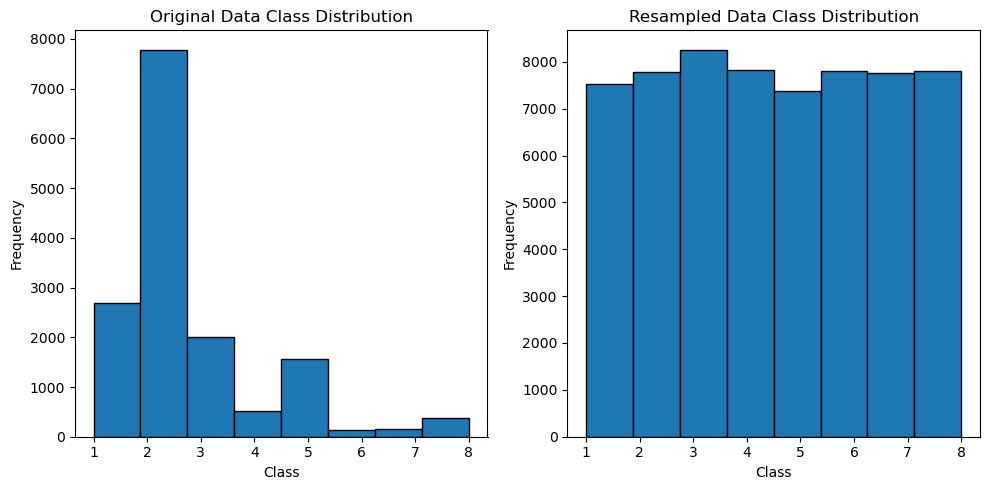

In [10]:
# Apply ADASYN for over-sampling
adasyn = ADASYN(random_state=0)
X_train_resampled, y_train_resampled = adasyn.fit_resample(X_train_ss_mm, y_train)
print("Size of original training set:", len(X_train_ss_mm))
print("Size of resampled training set:", len(X_train_resampled))

#plot original and resampled data class distribution
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.hist(y_train, bins=8, edgecolor='black')
plt.title('Original Data Class Distribution')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.subplot(1, 2, 2)
plt.hist(y_train_resampled, bins=8, edgecolor='black')
plt.title('Resampled Data Class Distribution')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

SVM with resampled data

In [11]:
C = [1, 2.5, 5]
gamma = [0.001, 0.01, 0.1]
print(C)
print(gamma)

[1, 2.5, 5]
[0.001, 0.01, 0.1]


In [12]:
#SVM with resampled data
param_grid = {
    'C': C,
    'gamma': gamma,
    'kernel': ['rbf'],
}

# Create the SVM classifier
svm = SVC()

# Perform grid search
grid_search = GridSearchCV(svm, param_grid, cv=5, n_jobs=-1, verbose=2, scoring = weighted_accuracy_scorer)
grid_search.fit(X_train_resampled, y_train_resampled)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("\nBest Hyperparameters:", best_params)

# Train the SVM classifier with the best hyperparameters
svm_best = SVC(**best_params)
svm_best.fit(X_train_resampled, y_train_resampled)

# Make predictions on the training set
y_train_pred = svm_best.predict(X_train_resampled)

# Make predictions on the validation set
y_val_pred = svm_best.predict(X_val_ss_mm)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] END .........................C=1, gamma=0.1, kernel=rbf; total time= 2.8min
[CV] END .........................C=1, gamma=0.1, kernel=rbf; total time= 3.2min
[CV] END .........................C=1, gamma=0.1, kernel=rbf; total time= 3.3min
[CV] END .........................C=1, gamma=0.1, kernel=rbf; total time= 3.3min
[CV] END .........................C=1, gamma=0.1, kernel=rbf; total time= 3.4min
[CV] END ......................C=2.5, gamma=0.01, kernel=rbf; total time= 3.4min
[CV] END ........................C=1, gamma=0.01, kernel=rbf; total time= 3.9min
[CV] END ......................C=2.5, gamma=0.01, kernel=rbf; total time= 3.9min
[CV] END ......................C=2.5, gamma=0.01, kernel=rbf; total time= 4.0min
[CV] END ......................C=2.5, gamma=0.01, kernel=rbf; total time= 4.0min
[CV] END ........................C=1, gamma=0.01, kernel=rbf; total time= 4.4min
[CV] END ........................C=1, gamma=0.01,

In [14]:
# Print a classification reports
report = classification_report(y_train_resampled, y_train_pred, target_names=target_names)
print("Train Classification Report:")
print(report)

report = classification_report(y_val, y_val_pred, target_names=target_names)
print("Validation Classification Report:")
print(report)

# Calculate train weighted accuracy
train_weighted_acc = weighted_accuracy(y_train, y_train_pred, class_weights)
print("Train Weighted Accuracy:", train_weighted_acc)

# Calculate validation weighted accuracy
validation_weighted_acc = weighted_accuracy(y_val, y_val_pred, class_weights)
print("Validation Weighted Accuracy:", validation_weighted_acc)

Train Classification Report:
                         precision    recall  f1-score   support

               Melanoma       0.96      0.98      0.97      7533
      Melanocytic nevus       0.99      0.94      0.96      7784
   Basal cell carcinoma       0.99      1.00      0.99      8259
      Actinic keratosis       1.00      1.00      1.00      7829
       Benign keratosis       0.98      0.99      0.99      7382
         Dermatofibroma       1.00      1.00      1.00      7797
        Vascular lesion       1.00      1.00      1.00      7764
Squamous cell carcinoma       1.00      1.00      1.00      7809

               accuracy                           0.99     62157
              macro avg       0.99      0.99      0.99     62157
           weighted avg       0.99      0.99      0.99     62157

Validation Classification Report:
                         precision    recall  f1-score   support

               Melanoma       0.51      0.54      0.52       701
      Melanocytic nevus

In [20]:
# saving test results to csv
y_test_pred = svm_best.predict(X_test_ss_mm)
ids_test = df_test['ID']
tosave = pd.DataFrame({'ID': ids_test, 'CLASS': y_test_pred})
tosave.to_csv('test_results_svm_oversamp.csv', index=False)

The model is overfitted, find best hyperparameters is more costly.